## [Computational Social Science] Project 5: Natural Language Processing

### Team 4: Elleni Hailu, Lawrence Liu, and Ángel Mendiola Ross
### Due: February 26, 2020

In this project, we use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, we do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

We explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#install spacy language detect capability, uncomment below if not yet installed 
#!pip install spacy-langdetect

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation

from spacy.lang.en.stop_words import STOP_WORDS
from spacy_langdetect import LanguageDetector #so we can add a feature to the dataframe indicating whether English text or not

import en_core_web_sm
nlp = en_core_web_sm.load()

#add language detection to spaCy pipeline
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#replicabilty
import random

#regex to help remove graphical emojis
import re 

import multiprocessing


In [3]:
#random.seed(49764) #set seed for replicability w/ sample

congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(5000, random_state = 49764) 
#LL: note I picked 5000 arbitrarily for now; we'll want to come back to this and adjust up as we get code to work
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
282342,1.154190e+18,SenDuckworth,2019-07-24T20:47:25-04:00,I’m committed to defending critical safety net...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
611053,1.116700e+18,RepAdams,2019-04-12T10:02:00-04:00,"During the first #100DaysForThePeople, the Hou...",Alma Adams,Rep,4-Nov-14,5/27/1946,F,NC,12,Democrat,"2,362,631","2,189,316","2,178,391","2,270,395"
348843,1.204830e+18,McConnellPress,2019-12-11T13:41:44-05:00,"RT @senatemajldr Yesterday, House Democrats co...",Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190"
809599,1.250870e+18,RepKayGranger,2020-04-16T15:26:20-04:00,In just 2 weeks the #PaycheckProtectionProgram...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,12,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
441755,1.170340e+18,BettyMcCollum04,2019-09-07T10:31:01-04:00,As Chair of the Interior Appropriations Subcom...,Betty McCollum,Rep,3-Jan-01,7/12/1954,F,MN,4,Democrat,"1,322,951","1,367,716","1,546,167","1,320,225"


In [4]:
congress_tweets = congress_tweets.reset_index(drop = True)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.154190e+18,SenDuckworth,2019-07-24T20:47:25-04:00,I’m committed to defending critical safety net...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
1,1.116700e+18,RepAdams,2019-04-12T10:02:00-04:00,"During the first #100DaysForThePeople, the Hou...",Alma Adams,Rep,4-Nov-14,5/27/1946,F,NC,12,Democrat,"2,362,631","2,189,316","2,178,391","2,270,395"
2,1.204830e+18,McConnellPress,2019-12-11T13:41:44-05:00,"RT @senatemajldr Yesterday, House Democrats co...",Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190"
3,1.250870e+18,RepKayGranger,2020-04-16T15:26:20-04:00,In just 2 weeks the #PaycheckProtectionProgram...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,12,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.170340e+18,BettyMcCollum04,2019-09-07T10:31:01-04:00,As Chair of the Interior Appropriations Subcom...,Betty McCollum,Rep,3-Jan-01,7/12/1954,F,MN,4,Democrat,"1,322,951","1,367,716","1,546,167","1,320,225"


In [5]:
congress_tweets.shape

(5000, 16)

## Preprocessing Text Data

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
#function to remove graphical emojis
#copied from: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/50602709#50602709

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [8]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation) #should get rid of hashtags and @s
    
    punc_free = "".join([ch for ch in text if ch not in punc]) #turns text into a string object
    
    punc_free = punc_free.lower() #lower-case the words
    
    punc_free = punc_free.replace('rt', '') #delete rt
    
    punc_free = punc_free.replace('qt', '') #delete qt
    
    punc_free = punc_free.replace('amp', '') #delete ampersand
    
    #punc_free = re.sub(r'#*', '', punc_free) #remove repeated #s
    
    punc_free = deEmojify(punc_free) #remove graphical emojis
    
    punc_free = " ".join(punc_free.split()) #removes all whitespace characters (space, line breaks, etc.)
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [9]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [committed, defending, critical, safety, net, ...
1       [100daysfohepeople, house, passed, hr, 1, fohe...
2       [senatemajldr, yesterday, house, democrats, co...
3       [2, weeks, paycheckprotectionprogram, funds, v...
4       [chair, interior, appropriations, subcommittee...
                              ...                        
4995    [waltshaub, joining, panel, testify, wednesday...
4996    [oscar, grant, 22, year, old, black, man, shot...
4997    [live, m, answering, questions, telephone, tow...
4998    [repratcliffe, 3500, pages, transcripts, relea...
4999    [great, meeting, ag, nominee, bill, barr, toda...
Name: tokens, Length: 5000, dtype: object

## Adding Feature Indicating the Tweet Language

Since some of the tweets are in non-English languages, we added a column to the dataframe that indicates the language of the tweet as identified by spaCy. 

In [10]:
#example of how it works and what is output
test_text = ['.', 'this is a test string']
for text in test_text:
    doc = nlp(text)
    print(doc._.language)

{'language': 'UNKNOWN', 'score': 0.0}
{'language': 'en', 'score': 0.9999943396318447}


In [11]:
#code adapted from: https://www.kaggle.com/shawamar/language-detection-using-spacy
#LL note 2/14/21: note that w/ 5000 tweets, this took me ~3 minutes to run

#create container for tweet languages and loop through text column of dataframe
tweets = congress_tweets['text']
languages_spacy = []

for text in tweets:
    doc = nlp(text)
    languages_spacy.append(list(doc._.language.values())[0])

#add column to df indicating language of tweet
congress_tweets['languages_spacy'] = languages_spacy

In [12]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,languages_spacy
0,1.154190e+18,SenDuckworth,2019-07-24T20:47:25-04:00,I’m committed to defending critical safety net...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[committed, defending, critical, safety, net, ...",en
1,1.116700e+18,RepAdams,2019-04-12T10:02:00-04:00,"During the first #100DaysForThePeople, the Hou...",Alma Adams,Rep,4-Nov-14,5/27/1946,F,NC,12,Democrat,"2,362,631","2,189,316","2,178,391","2,270,395","[100daysfohepeople, house, passed, hr, 1, fohe...",en
2,1.204830e+18,McConnellPress,2019-12-11T13:41:44-05:00,"RT @senatemajldr Yesterday, House Democrats co...",Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[senatemajldr, yesterday, house, democrats, co...",en
3,1.250870e+18,RepKayGranger,2020-04-16T15:26:20-04:00,In just 2 weeks the #PaycheckProtectionProgram...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,12,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[2, weeks, paycheckprotectionprogram, funds, v...",en
4,1.170340e+18,BettyMcCollum04,2019-09-07T10:31:01-04:00,As Chair of the Interior Appropriations Subcom...,Betty McCollum,Rep,3-Jan-01,7/12/1954,F,MN,4,Democrat,"1,322,951","1,367,716","1,546,167","1,320,225","[chair, interior, appropriations, subcommittee...",en


In [13]:
#drop rows for which there is missing data
congress_tweets.dropna()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,languages_spacy
0,1.154190e+18,SenDuckworth,2019-07-24T20:47:25-04:00,I’m committed to defending critical safety net...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[committed, defending, critical, safety, net, ...",en
1,1.116700e+18,RepAdams,2019-04-12T10:02:00-04:00,"During the first #100DaysForThePeople, the Hou...",Alma Adams,Rep,4-Nov-14,5/27/1946,F,NC,12,Democrat,"2,362,631","2,189,316","2,178,391","2,270,395","[100daysfohepeople, house, passed, hr, 1, fohe...",en
2,1.204830e+18,McConnellPress,2019-12-11T13:41:44-05:00,"RT @senatemajldr Yesterday, House Democrats co...",Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[senatemajldr, yesterday, house, democrats, co...",en
3,1.250870e+18,RepKayGranger,2020-04-16T15:26:20-04:00,In just 2 weeks the #PaycheckProtectionProgram...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,TX,12,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[2, weeks, paycheckprotectionprogram, funds, v...",en
4,1.170340e+18,BettyMcCollum04,2019-09-07T10:31:01-04:00,As Chair of the Interior Appropriations Subcom...,Betty McCollum,Rep,3-Jan-01,7/12/1954,F,MN,4,Democrat,"1,322,951","1,367,716","1,546,167","1,320,225","[chair, interior, appropriations, subcommittee...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.092480e+18,RepSarbanes,2019-02-04T13:06:48-05:00,RT @waltshaub I’ll be joining this panel to te...,John Sarbanes,Rep,3-Jan-07,5/22/1962,M,MD,3,Democrat,"943,169","1,677,928","1,677,844","971,869","[waltshaub, joining, panel, testify, wednesday...",en
4996,1.174770e+18,RepRoKhanna,2019-09-19T15:34:00-04:00,"Oscar Grant, a 22 year old Black man, was shot...",Ro Khanna,Rep,3-Jan-17,9/13/1976,M,CA,17,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[oscar, grant, 22, year, old, black, man, shot...",en
4997,1.255640e+18,RepDMP,2020-04-29T19:18:26-04:00,🔴LIVE: I'm answering your questions on our tel...,Debbie Mucarsel-Powell,Rep,3-Jan-19,1/18/1971,F,FL,26,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[live, m, answering, questions, telephone, tow...",en
4998,1.196860e+18,RepTipton,2019-11-19T13:54:45-05:00,"RT @RepRatcliffe In the 3,500 pages of transcr...",Scott Tipton,Rep,3-Jan-11,11/9/1956,M,CO,3,Republican,"1,202,484","1,338,870","1,323,102","1,185,243","[repratcliffe, 3500, pages, transcripts, relea...",en


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

Before beginning our EDA, we wanted to get a feel for our data so we first plot a series of count plots.

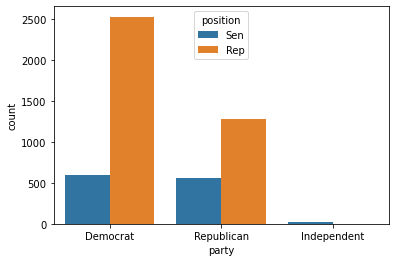

In [14]:
# looking at the number of tweets by Dem/Repub and by Senator/Representative
sns.countplot(x="party", hue = "position", data=congress_tweets);

The plot above shows that representatives tweet more than Senators. But this may be due to the fact that there are more representatives than senators. It also appears that among Representatives, Democrats tweet more than Republicans. But lets look at the underlying makeup of our data.

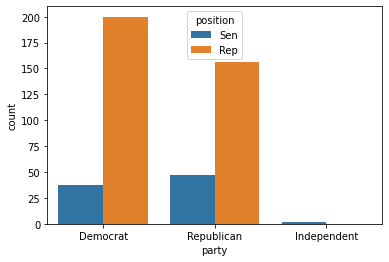

In [15]:
# looking at the number of tweets by Dem/Repub and by Senator/Representative
# plotting only unique rows
test = congress_tweets.drop_duplicates(subset = ["screen_name"])
sns.countplot(x="party", hue = "position", data=test);

In [16]:
# getting the numbers from the plots above
pd.crosstab(test.party, test.position)

position,Rep,Sen
party,,
Democrat,200,37
Independent,0,2
Republican,156,47


We see a similar breakdown looking only at breakdown of Senators and Representatives in our dataset. Comparing the results to the first plot suggests that Democratic Representatives do tweet more than Republican representatives. While there are clearly more Democratic representatives than Republicans (200 compared to 156), Democratic Representatives tweeted 2,537 times while Republican Representatives tweeted 1,272 times.

Before moving on, we want to check if these findings are driven in part by gender. We may expect, for example, that male members of Congress tweet more than female members.

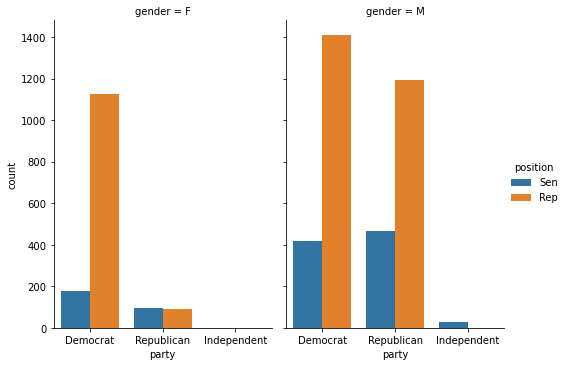

In [17]:
sns.catplot(x="party", hue = "position", col="gender",
            data=congress_tweets, kind="count",
            height=5, aspect=.7);

While Democratic Representatives still tweet more than Republicans, male Representatives in both parties tweet more than their female counterparts (but this is also likely influenced by the fact that there are more male representatives than female representatives).

### EDA 1

To get a better sense of common words, we first plot a word cloud of the tweets.

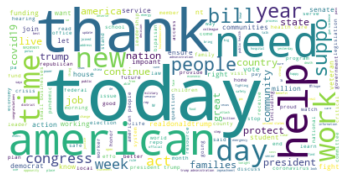

In [18]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Convert list of tokens back to string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
# feed string to wordcloud
wordcloud = WordCloud(background_color = "white").generate(text)
# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Many of the largest words in the word cloud are fairly predictable: today, american, thank, work, and help.

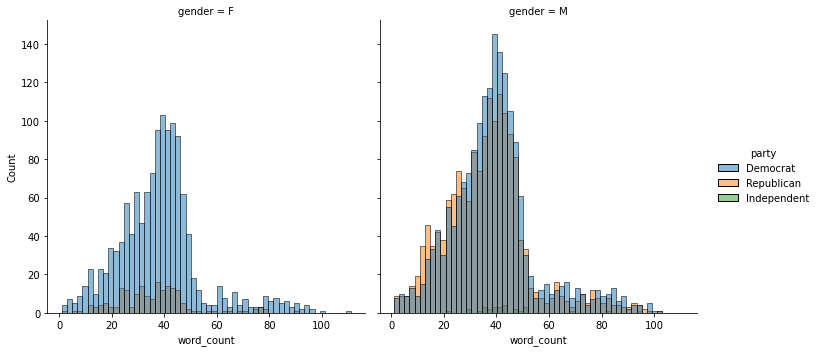

In [19]:
# adding length columns
congress_tweets['tweet_len'] = congress_tweets['text'].apply(len)
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))
sns.displot(congress_tweets, x="word_count", hue = "party", col = "gender")
plt.show()

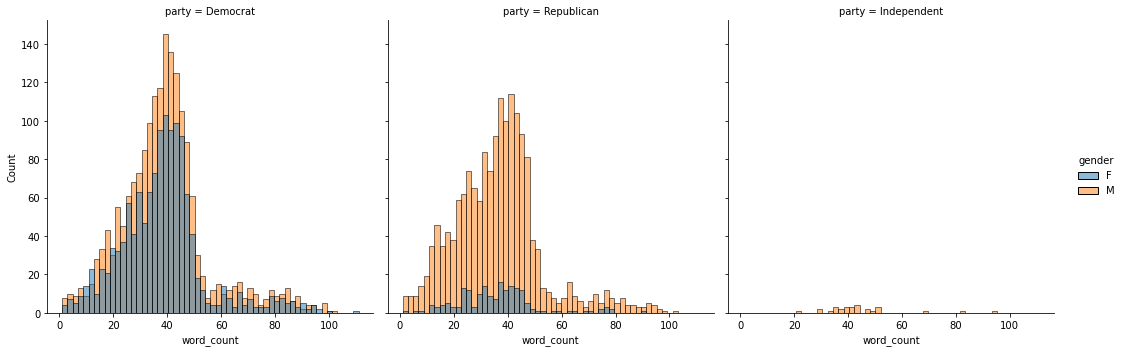

In [20]:
sns.displot(congress_tweets, x="word_count", hue = "gender", col = "party")
plt.show()

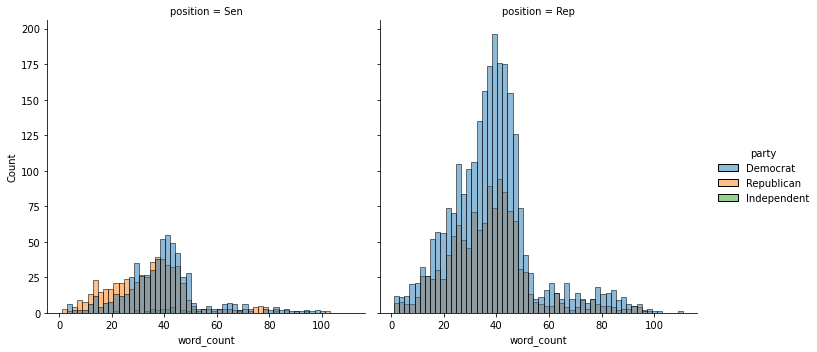

In [21]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "position")
plt.show()

### EDA 2

For our second EDA, we opted to try LDA topic-modeling.

In [22]:
# removing Independent representatives because it's only a few representatives but pretty distinct from Repub/Dem
no_indep = congress_tweets[congress_tweets.party != 'Independent']
X = no_indep['text']

tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [24]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [25]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
health small care need businesses act bill americans help today program relief funding assistance covid19 president people pandemic time american

Topic #1:
today people trump president house work health american time community congress ” tune great “ – communities live senate suppo

Topic #2:
today thank “ act president great american ” need families trump working congress statement help new mask day realdonaldtrump state

Topic #3:
health today care trump americans act new families law protect president covid19 workers suppo people work american thank time bill

Topic #4:
today help day work trump covid19 house — act president women working need congress bill thank people american community ️

Topic #5:
today house people gun violence ” bill “ president background senate new ️ congress trump american help act vote bipaisan

Topic #6:
thank today people house realdonaldtrump time covid19 act day trump fight nation country years work senate americans stop service week



In [26]:
# assigning topic weights
topic_dist = lda.transform(tfidf_matrix)

topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(no_indep.reset_index())

grouped = df_w_topics.groupby('party')
for i in range(0, 7):
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat      0.186857
Republican    0.168352
Name: 0, dtype: float64
party
Democrat      0.140683
Republican    0.122885
Name: 1, dtype: float64
party
Republican    0.130813
Democrat      0.125847
Name: 2, dtype: float64
party
Republican    0.171206
Democrat      0.169845
Name: 3, dtype: float64
party
Republican    0.156434
Democrat      0.146955
Name: 4, dtype: float64
party
Democrat      0.128135
Republican    0.117581
Name: 5, dtype: float64
party
Republican    0.132728
Democrat      0.101677
Name: 6, dtype: float64


Topics 0 and 6 seem to have the most divergence--even though the differences are pretty small. We tried a range of topic sizes (e.g., 4 to 30) and these were the best we could get. Most differences were less than one percentage point.

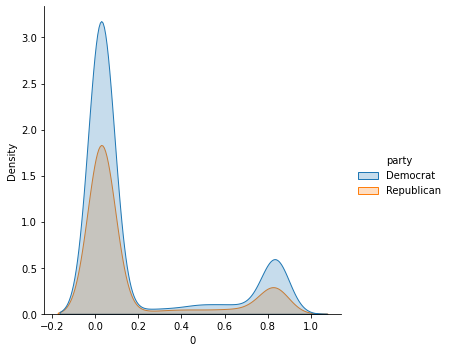

In [27]:
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

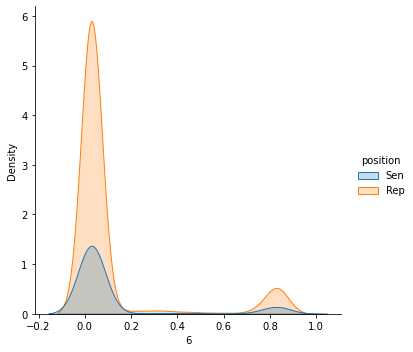

In [28]:
sns.displot(df_w_topics, x=df_w_topics[6], hue = "position", kind = 'kde', fill = 'true')
plt.show()

Ultimately, the topics do not distinguish well between Senators and Representatives or Republicans and Democrats.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [29]:
# More conservative representative: Paul Gosar
congress_tweets['tokens_string'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
pg_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Paul Gosar']

pg_tweets['polarity'] = pg_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.polarity)
pg_tweets['subjectivity'] = pg_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# More liberal representative: Barbara Lee
bl_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Barbara Lee']
bl_tweets['polarity'] = bl_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.polarity)
bl_tweets['subjectivity'] = bl_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# combining data frames
frames = [pg_tweets, bl_tweets]
polarity_df = pd.concat(frames)

<ipython-input-29-eb2c41df38c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pg_tweets['polarity'] = pg_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-29-eb2c41df38c7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pg_tweets['subjectivity'] = pg_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.subjectivity)
<ipython-input-29-eb2c41df38c7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

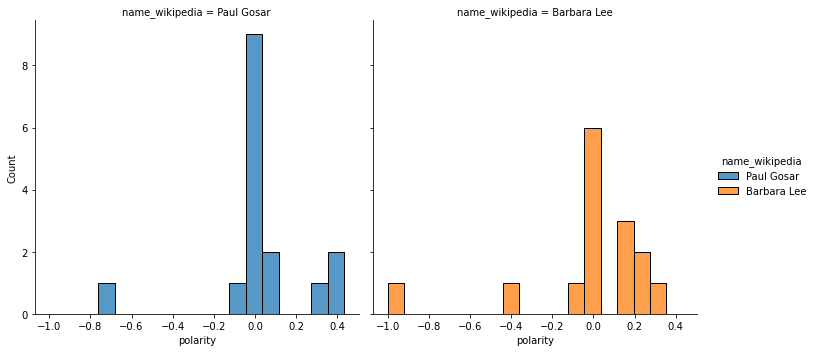

In [30]:
sns.displot(polarity_df, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [31]:
# checking most negative tweets for Barbara Lee
for tweet in bl_tweets.nsmallest(2, 'polarity')['text']:
    print(tweet + "\n")

It's disgusting that Trump continues to push policies that harm our families.

These attacks on programs that help address homelessness need to stop. https://www.sfchronicle.com/opinion/editorials/article/Editorial-Trump-fights-against-proven-homeless-14894252.php

This pandemic has exposed the outrageous and deadly consequences of structural racism and discriminatory care. We must address these deep disparities in our response.    https://www.nytimes.com/2020/05/10/us/coronavirus-african-americans-bias.html



In [32]:
# checking most negative tweets for Paul Gosar
for tweet in pg_tweets.nsmallest(2, 'polarity')['text']:
    print(tweet + "\n")

On September 11, 2001, almost 3,000 people lost their lives during the attacks at the Twin Towers, Pentagon and aboard United Airlines Flight 93. Today we remember and honor the lives we lost on that very tragic day. #NeverForget http://pbs.twimg.com/media/Ehpzje_WoAkrmJB.jpg

RT @SecBernhardt This may be the most consequential change in administrative environmental practice in 50 years and will be a massive boon for the American people. Radical activists and overpaid consultants will hate the commonsense approach! https://twitter.com/whitehouse/status/1283493697343180801 QT @WhiteHouse We are reclaiming America's legacy as a nation of builders with a complete overhaul of the approval process for new infrastructure projects! http://pbs.twimg.com/media/Ec_itnkWkAExpl3.png https://video.twimg.com/amplify_video/1283493665558745088/vid/480x270/sVSjHsSnZLlVe7QY.mp4?tag=13



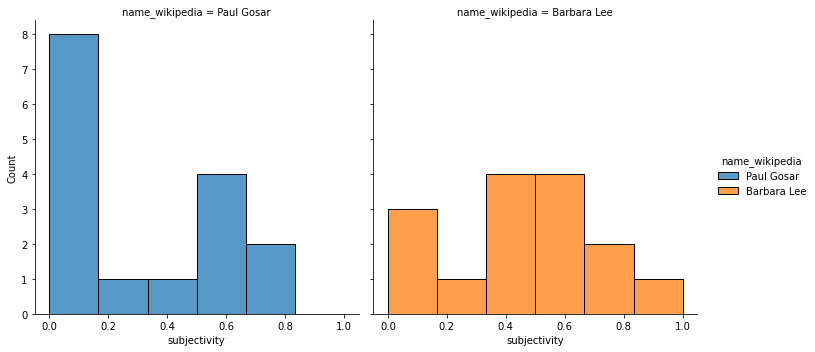

In [33]:
sns.displot(polarity_df, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [34]:
# checking most subjective tweet for Barbara Lee
for tweet in bl_tweets.nlargest(3, 'subjectivity')['text']:
    print(tweet + "\n")

It's disgusting that Trump continues to push policies that harm our families.

These attacks on programs that help address homelessness need to stop. https://www.sfchronicle.com/opinion/editorials/article/Editorial-Trump-fights-against-proven-homeless-14894252.php

My thoughts are with the people of #Aurora as yet another community in our country deals with senseless tragedy. Gun violence is a national epidemic, and it’s taken Congress far too long to address it.

Trump’s latest attempt to bypass his constitutional duty to seek Congressional authority and send more troops to the region while selling Saudi Arabia arms only escalates tensions. It’s past time for Congress to reclaim its authority and stop this careless barreling toward war



In [35]:
# checking most subjective tweet for Paul Gosar
for tweet in pg_tweets.nlargest(3, 'subjectivity')['text']:
    print(tweet + "\n")

On September 11, 2001, almost 3,000 people lost their lives during the attacks at the Twin Towers, Pentagon and aboard United Airlines Flight 93. Today we remember and honor the lives we lost on that very tragic day. #NeverForget http://pbs.twimg.com/media/Ehpzje_WoAkrmJB.jpg

RT @realDonaldTrump .@GOP  We were put in this position of power and importance to make decisions for the people who so proudly elected us, the most important of which has long been considered to be the selection of United States Supreme Court Justices. We have this obligation, without delay!

Congratulations to Judge Amy Coney Barrett. She is a brilliant choice and will interpret our beloved constitution as written. As the Supreme Court heads into it’s new term on October 5th, the American people look forward to her prompt confirmation. #SCOTUS https://twitter.com/whitehouse/status/1309962890376552449 QT @WhiteHouse President @realDonaldTrump's nominee for Associate Justice of the Supreme Court is Judge Amy Cone

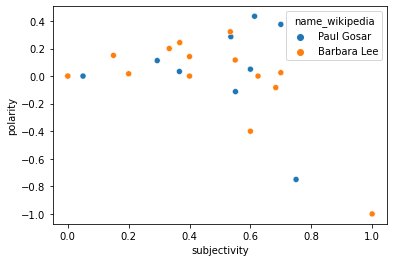

In [36]:
sns.scatterplot(x = polarity_df['subjectivity'], y = polarity_df['polarity'], hue = polarity_df['name_wikipedia'])

The scores for Representatives Paul Gosar (R) and Barbara Lee (D) do not match what we had originally thought. Given Trump's hold on the Republican Party and his outlandishly subjective and negative rhetoric, we thought that Rep. Gosar's tweets would be rated both more subjective and more negative than Rep. Lee's. But in fact, the opposite was true. Looking into what tweets ranked most negative, they are critiques of Trump and tweets pointing out the deadly consequences of structural racism and discriminatory care. For subjectivity, Rep. Lee's tweets about Trump's attacks on policies supporting unhoused people and the need to stop gun violence rank the most subjective. In comparison, Rep. Gosar's most subjective tweet is a 9/11 remembrance.

In [37]:
# now looking at subjectivity and polarity across all members
congress_tweets['polarity'] = congress_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.subjectivity)

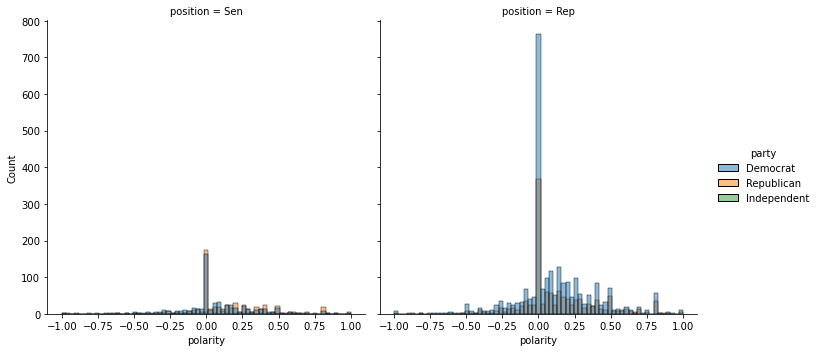

In [38]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "position")
plt.show()

In [39]:
# checking most negative tweets
for tweet in congress_tweets.nsmallest(3, 'polarity')['text']:
    print(tweet + "\n")

I feel terrible for the air traffic controllers and the many other federal employees who have been working through the shutdown. It is unconscionable that we make people work without pay. #ShutdownFairnessAct

RT @AmericasVoice California @RepCardenas says family separation is the worst thing that can happen to a child. #FamiliesBelongTogether http://pbs.twimg.com/media/Dy6OVt3XcAAvJ3-.jpg

.@POTUS, the “headaches” caused by missiles won’t just go away b/c you want to pretend your horrible Iran policy is cost-free. Iraq &amp; Afghanistan vets know the staggering long-term price of TBI &amp; debilitating CTE, signature wounds of those conflicts. Actions have consequences.



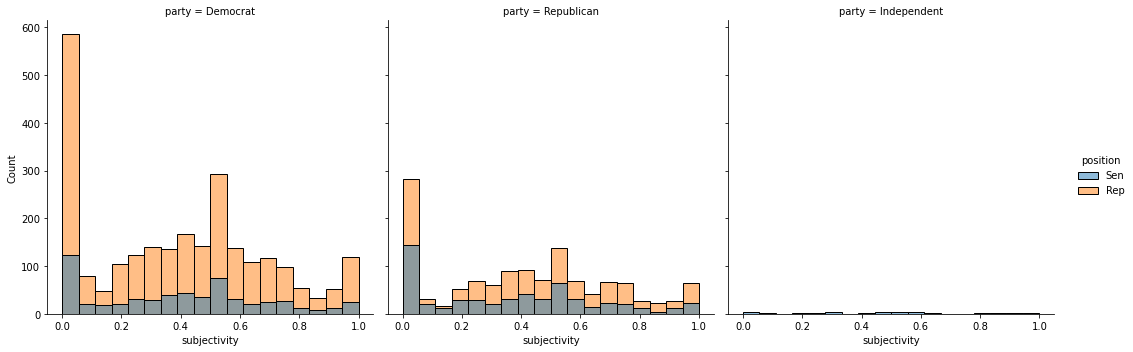

In [40]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "party")
plt.show()

In [41]:
# checking most subjective tweets
for tweet in congress_tweets.nlargest(5, 'subjectivity')['text']:
    print(tweet + "\n")

Today we honor and remember the brave Americans and Allied troops who stormed the beaches of Normandy to liberate Europe from Nazi tyranny. #75DDay http://pbs.twimg.com/media/D8Z_5r0XoBgxRZR.jpg

This G-7 announcement is corrupt. It's a violation of the Constitution. It's an abuse of power. And Congress can shut it down. I'm introducing a bill first thing next week to stop this corruption in it's tracks. More to come...

Congrats to our next Secretary of the @usairforce Barbara Barrett! https://twitter.com/senategop/status/1184579728856047621 QT @SenateGOP ✅CONFIRMED

The United States Senate has confirmed Barbara Barrett as Secretary of the @usairforce. http://pbs.twimg.com/media/EHB6CiLW4AAs0DT.jpg https://video.twimg.com/ext_tw_video/1184579644504367111/pu/vid/540x270/0Qt_Q9orpFmgXir9.mp4?tag=10

#HBCUs are a key partner for @Dell. #DiversityInTech http://pbs.twimg.com/media/EiiEWnsXsAI1FjH.jpg

Danny’s mother took her immense pain and made it her mission to ensure that no other fam

The trends by party and chamber on both polarity and subjectivity look fairly similar. It appears that roughly 100 tweets ranked most subjectivity (e.g., 1 on subjectivity) come from Democratic Representatives (about double the number of Republican representatives. If we look at some of the tweets ranked most subjective, however, they include a remembrance of D-Day and a tweet about diversity in tech.

## Featurization

Below, we create three dataframes or arrays to represent our text features, specifically:

* Features engineered from our previous analyses: tweet length, word count, polarity, subjectivity, and language. 
* A term frequency-inverse document frequency matrix. 
* A document averaged word2vec.


Before continuing, we remove tweets by Independents from our data set, and we turn the languages variable into integers via one-hot encoding.

In [42]:
# removing Independent representatives because it's only a few representatives but pretty distinct from Repub/Dem
no_indep = congress_tweets[congress_tweets.party != 'Independent']
no_indep = no_indep.reset_index()

#turn languages variable into integers 
language_oneHot  = pd.get_dummies(no_indep['languages_spacy'])
no_indep = no_indep.join(language_oneHot)

#take a look at column names
no_indep.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'languages_spacy', 'tweet_len',
       'word_count', 'tokens_string', 'polarity', 'subjectivity', 'UNKNOWN',
       'af', 'cs', 'de', 'en', 'es', 'fr', 'id', 'it', 'nl', 'ro', 'so', 'sv',
       'tl', 'zh-cn'],
      dtype='object')

### Engineered Text Features

In [43]:
# Engineered Features
engineered_features = no_indep[['tweet_len', 'word_count', 'polarity', 'subjectivity', 
                                       'af', 'cs', 'de', 'en', 'es', 'fr', 
                               'UNKNOWN', 'id', 'it', 'nl', 'ro', 'tl', 'zh-cn']].reset_index(drop = True)
# AMR: tr and sv were not in index so I removed

# Topic Model + Engineered Features
#engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

### Tf-idf

In [44]:
# tf-idf featurization
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

### Word Embedding

We rely on the pre-trained Google News word2vec embedding model. We decide not to merge this with an embedding model built on our corpus given limited computational resources and a belief that there should be fairly high overlap between words in Google News and tweets by politicians.

In [45]:
# Load Word2Vec model from Google
# AMR: it saved for me as .bin rather than .bin.gz so may need to update
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary = True) 

We discovered there are a number of rows  that have no tokens or have no tokens that also exist in the embedding model. We therefore need to remove those rows from the dataset.

In [46]:
#code to remove rows for tweets w/ 0 tokens and/or no tokens in the embedding model
locations = []

#LL: sorry this is bad Python code below, plz fix if you know a cleaner way to do it!
i=0
for tweet in no_indep['tokens']:
    doc = [word for word in tweet if word in model.wv.vocab]
    if len(doc) == 0:
        locations.append(i)
    i += 1

print(locations)

[212, 219, 237, 439, 487, 507, 641, 722, 753, 819, 979, 1359, 1443, 1492, 1517, 1646, 1944, 2093, 2316, 2511, 2706, 2793, 2810, 2853, 2873, 3417, 3781, 3820, 3889, 4163, 4221]


<ipython-input-46-7744f6220fa7>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  doc = [word for word in tweet if word in model.wv.vocab]


In [47]:
no_indep_withTokens = no_indep.drop(locations)

In [48]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#def document_vector(word2vec_model, doc):
#    doc = [word for word in doc if word in model.vocab]
#    return np.mean(model[doc], axis=0)


def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)


In [49]:
# embedding based featurization
words = list(model.wv.vocab)
print(words[0:100])

<ipython-input-49-9a005d0fa935>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  words = list(model.wv.vocab)


['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'It', 'all', 'also', 'two', 'after', 'first', 'He', 'do', 'time', 'than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'In', 'our', 'there', 'A', 'she', 'could', 'just', 'years', 'some', 'U.S.', 'three', 'million', 'them', 'what', 'But', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', '#.#', 'before']


In [50]:
# Initialize an array for the size of the corpus

empty_list_embeddings_means = []
for doc in no_indep_withTokens['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array


<ipython-input-48-d09af15b8683>:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  doc = [word for word in doc if word in model.wv.vocab]
<ipython-input-48-d09af15b8683>:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)


In [51]:
doc_average_embeddings.shape

(4941, 300)

Since the dataframes need to have the same number of rows for the classification techniques to follow, we now drop the rows with no tokens or without tokens that appear in the embedding model

In [52]:
engineered_features = engineered_features.drop(locations)
print(engineered_features.shape)

tfidf_df = tfidf_df.drop(locations)
print(tfidf_df.shape)

(4941, 17)
(4941, 17916)


In [53]:
dataframes = [engineered_features, 
              tfidf_df, 
              doc_average_embeddings,
             ]

featurization_technique = ['Engineered Text Features',
                            'Tf-idf Features',
                           "Document Average Embeddings"]

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

In [54]:
#define target variable
lb_style = LabelBinarizer()
party = no_indep_withTokens['party_binary'] = lb_style.fit_transform(no_indep_withTokens["party"])
chamber = no_indep_withTokens['chamber_binary'] = lb_style.fit_transform(no_indep_withTokens['position'])

In [55]:
no_indep_withTokens.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,id,it,nl,ro,so,sv,tl,zh-cn,party_binary,chamber_binary
0,0,1.154190e+18,SenDuckworth,2019-07-24T20:47:25-04:00,I’m committed to defending critical safety net...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,F,...,0,0,0,0,0,0,0,0,0,1
1,1,1.116700e+18,RepAdams,2019-04-12T10:02:00-04:00,"During the first #100DaysForThePeople, the Hou...",Alma Adams,Rep,4-Nov-14,5/27/1946,F,...,0,0,0,0,0,0,0,0,0,0
2,2,1.204830e+18,McConnellPress,2019-12-11T13:41:44-05:00,"RT @senatemajldr Yesterday, House Democrats co...",Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,...,0,0,0,0,0,0,0,0,1,1
3,3,1.250870e+18,RepKayGranger,2020-04-16T15:26:20-04:00,In just 2 weeks the #PaycheckProtectionProgram...,Kay Granger,Rep,3-Jan-97,1/18/1943,F,...,0,0,0,0,0,0,0,0,1,0
4,4,1.170340e+18,BettyMcCollum04,2019-09-07T10:31:01-04:00,As Chair of the Interior Appropriations Subcom...,Betty McCollum,Rep,3-Jan-01,7/12/1954,F,...,0,0,0,0,0,0,0,0,0,0


### Train Six Models with Just Text

#### Party Classification

We begin by seeing how well our three dataframes predict party affiliation using a logistic regression model.

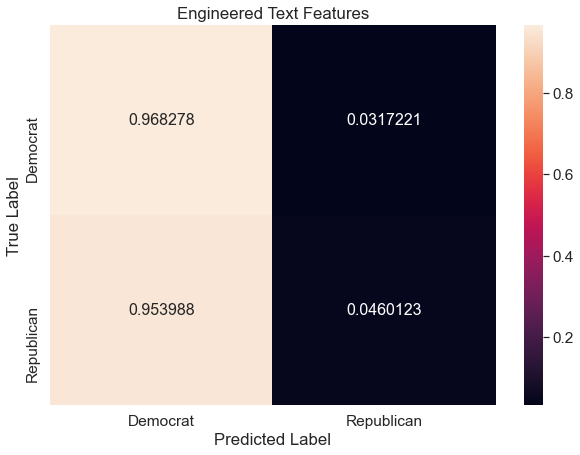

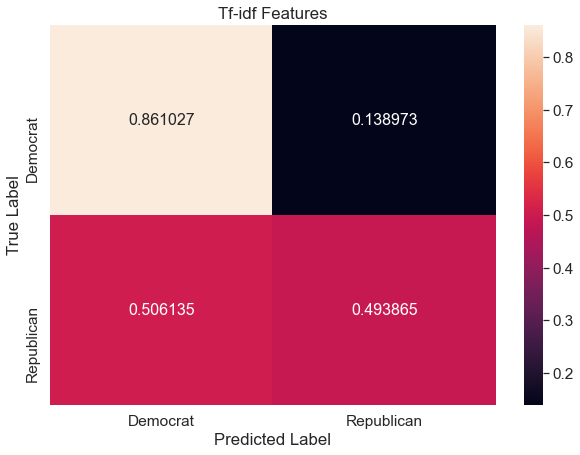

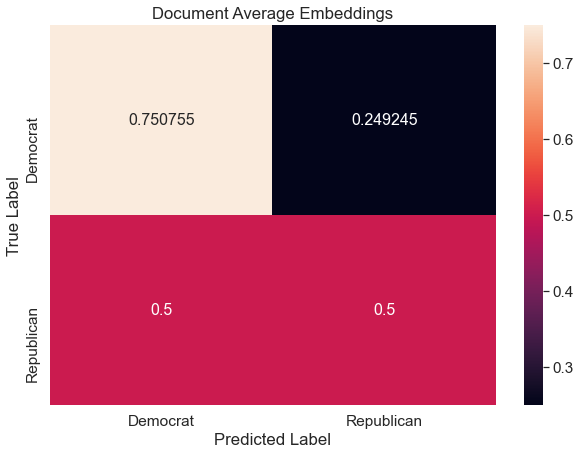

In [56]:
scaler = StandardScaler()

#logistic regression to predict party

for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, party, test_size=0.2, random_state=10) 
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)
    X_test_scaled = scaler.fit_transform(X_test)
 
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train_scaled, y_train.ravel())

    y_pred = logit_model.predict(X_val_scaled)
    
    cf_matrix = confusion_matrix(y_val, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Although the engineered text features appears to perform well at predicting Democrat tweets, we notice that this is because our algorithim guesses Democrat each time. Based on the confusion matrices above, it looks like the tf-idf performs best. Let's see if we can tune the logistic regression hyperparemeters to perform even better.

In [57]:
#determine number of cores for purposes of hyperparameter tuning
cores = multiprocessing.cpu_count()
cores

12

In [58]:
##the tf-idf param_grid is taking forever, so went ahead and stopped it. We can try and run it once the whole notebook is 
#done if we want

# for dataframe, featurization in zip(dataframes, featurization_technique):
#     X_train, X_test, y_train, y_test = train_test_split(dataframe, party, test_size=0.2, random_state=10) 
    
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)
    
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.fit_transform(X_val)
#     X_test_scaled = scaler.fit_transform(X_test)
    
#     # Choice of regularization parameter (must be strictly positive, larger values of C indicate
#     # weaker regularization strength)
#     C = list(np.arange(0.1,2.1,0.5))
#     # Optimization algorithm 
#     solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#     # Whether to fit intercept
#     fit_intercept = [True, False]
#     # Maximum number of iterations
#     max_iter = list(np.arange(100, 1000, 100))
    
#     # Create the random grid
#     param_grid_log_reg = {'C': C, 
#                'solver': solver,
#                'fit_intercept': fit_intercept,
#                'max_iter': max_iter}
    
#     # create a model
#     logit_reg = LogisticRegression()
    
#     # Random search of parameters, using 3 fold cross validation,
#     log_reg_grid = GridSearchCV(logit_reg, param_grid_log_reg, cv = 3, n_jobs= cores-1, verbose = 2)
#     log_reg_grid.fit(X_train_scaled, y_train.ravel())
    
#     best_index_log_reg = np.argmax(log_reg_grid.cv_results_["mean_test_score"])
#     print(log_reg_grid.cv_results_["params"][best_index_log_reg])
#     best_log_reg = LogisticRegression(**log_reg_grid.cv_results_["params"][best_index_log_reg])
    
    
#     # fit the model
#     logit_model = best_log_reg.fit(X_train_scaled, y_train.ravel())
    
#     #predit on validation X
#     y_pred = logit_model.predict(X_val_scaled)
    
#     #plot confusion matrices
#     cf_matrix = confusion_matrix(y_val, y_pred, normalize = "true")

#     df_cm = pd.DataFrame(cf_matrix, range(2),
#                       range(2))

#     df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
#     df_cm.index = ["Democrat", "Republican"]
#     plt.figure(figsize = (10,7))
#     sns.set(font_scale=1.4)#for label size
#     sns.heatmap(df_cm, 
#                annot=True,
#                annot_kws={"size": 16},
#                fmt='g')

#     plt.title(featurization)
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

Among these three sets of features, it looks like XXXX performs the best. We will combine that dataframe with our non-text features below.

#### Chamber Classification

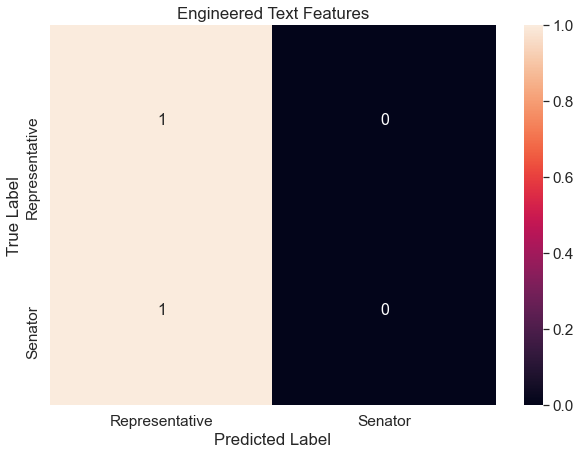

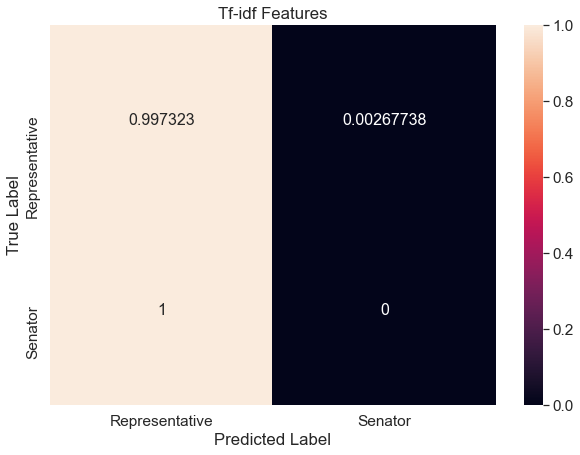

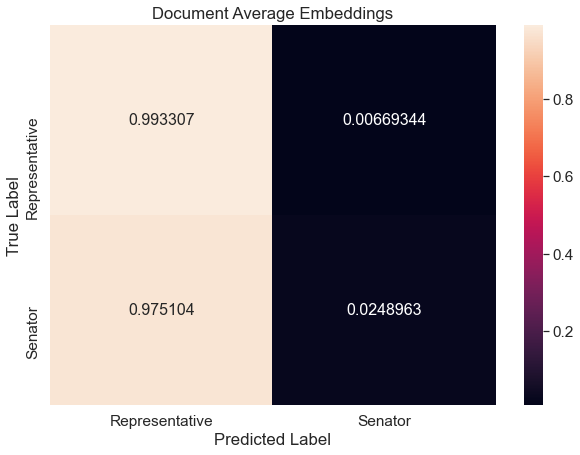

In [59]:
#logistic regression to predict position
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, chamber, test_size=0.2, random_state=10) 
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)
    X_test_scaled = scaler.fit_transform(X_test)
    
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_val)
    
    cf_matrix = confusion_matrix(y_val, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [60]:
##commenting out hyperparm tuning for now given how long it takes for tf_idf features

# for dataframe, featurization in zip(dataframes, featurization_technique):

#     X_train, X_test, y_train, y_test = train_test_split(dataframe, chamber, test_size=0.2, random_state=10) 
    
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)
    
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.fit_transform(X_val)
#     X_test_scaled = scaler.fit_transform(X_test)
    
#     # Choice of regularization parameter (must be strictly positive, larger values of C indicate
#     # weaker regularization strength)
#     C = list(np.arange(0.1,2.1,0.5))
#     # Optimization algorithm 
#     solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#     # Whether to fit intercept
#     fit_intercept = [True, False]
#     # Maximum number of iterations
#     max_iter = list(np.arange(100, 1000, 100))
    
#     # Create the random grid
#     param_grid_log_reg = {'C': C, 
#                'solver': solver,
#                'fit_intercept': fit_intercept,
#                'max_iter': max_iter}
    
#     # create a model
#     logit_reg = LogisticRegression()
    
#     # Random search of parameters, using 3 fold cross validation,
#     log_reg_grid = GridSearchCV(logit_reg, param_grid_log_reg, cv = 3, n_jobs= cores-1, verbose = 2)
#     log_reg_grid.fit(X_train_scaled, y_train.ravel())
    
#     best_index_log_reg = np.argmax(log_reg_grid.cv_results_["mean_test_score"])
#     print(log_reg_grid.cv_results_["params"][best_index_log_reg])
#     best_log_reg = LogisticRegression(**log_reg_grid.cv_results_["params"][best_index_log_reg])
    
    
#     # fit the model
#     logit_model = best_log_reg.fit(X_train_scaled, y_train.ravel())
    
#     #predit on validation X
#     y_pred = logit_model.predict(X_val_scaled)
    
#     #plot confusion matrices
#     cf_matrix = confusion_matrix(y_val, y_pred, normalize = "true")

#     df_cm = pd.DataFrame(cf_matrix, range(2),
#                       range(2))

#     df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
#     df_cm.index = ["Democrat", "Republican"]
#     plt.figure(figsize = (10,7))
#     sns.set(font_scale=1.4)#for label size
#     sns.heatmap(df_cm, 
#                annot=True,
#                annot_kws={"size": 16},
#                fmt='g')

#     plt.title(featurization)
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.show()

Among these three sets of features, it looks like the document-averaged embedding performs the best. We will combine that dataframe with our non-text features below.

### Two Combined Models

In [61]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

#grab column names of no_indepWithTokens dataset
print(no_indep_withTokens.columns)

#select non-text features, one-hot encode and/or binarize
##LL Note: feel free to add more columns. I just thought these made sense and didn't want to pick things
#that are too collinear, like Trump and Clinton vote share
non_text_features_with_y = no_indep_withTokens[['party', 'position', 'gender', 'clinton_2016_state_share', 'obama_2012_state_share']
                                      ].reset_index(drop = True)

non_text_features_with_y['party_binary'] = lb_style.fit_transform(non_text_features_with_y["party"])
non_text_features_with_y['chamber_binary'] = lb_style.fit_transform(non_text_features_with_y["position"])

state_oneHot  = pd.get_dummies(no_indep_withTokens['state'])
non_text_features_with_y = non_text_features_with_y.join(state_oneHot)

non_text_features_with_y['gender'] = lb_style.fit_transform(no_indep_withTokens["gender"])

#convert vote share from string to int
non_text_features_with_y["clinton_2016_state_share"] = non_text_features_with_y['clinton_2016_state_share'].str.replace(",", '').astype(int)
non_text_features_with_y["obama_2012_state_share"] = non_text_features_with_y['obama_2012_state_share'].str.replace(",", '').astype(int)

#join this one-hot-encoded dataframe of non-text features to the best text features for party
tfidf_df = tfidf_df.reset_index(drop = True)
combined_party = pd.concat([non_text_features_with_y, tfidf_df], axis=1)
combined_party = combined_party.dropna()

#join this one-hot-encoded dataframe of non-text features to the best text features for chamber
doc_average_embeddings_df = pd.DataFrame(doc_average_embeddings).reset_index(drop = True)
combined_chamber = pd.concat([non_text_features_with_y, doc_average_embeddings_df], axis=1)
combined_chamber = combined_chamber.dropna()

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'languages_spacy', 'tweet_len',
       'word_count', 'tokens_string', 'polarity', 'subjectivity', 'UNKNOWN',
       'af', 'cs', 'de', 'en', 'es', 'fr', 'id', 'it', 'nl', 'ro', 'so', 'sv',
       'tl', 'zh-cn', 'party_binary', 'chamber_binary'],
      dtype='object')


In [62]:
# creating targets
party = combined_party['party_binary']
chamber = combined_chamber['chamber_binary']

# dropping targets from X df
combined_party = combined_party.drop(['party', 'position', 'party_binary'], axis=1)
combined_chamber = combined_chamber.drop(['party', 'position', 'chamber_binary'], axis=1)

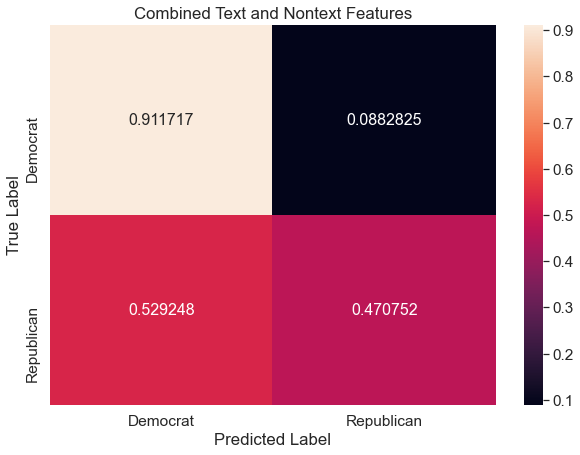

In [63]:
# party model
X_train, X_test, y_train, y_test = train_test_split(combined_party, party, test_size=0.2, random_state=10) 
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)
    
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)
 
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train_scaled, y_train.ravel())

y_pred = logit_model.predict(X_val_scaled)
    
cf_matrix = confusion_matrix(y_val, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                     range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

plt.title("Combined Text and Nontext Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The combined model improves our prediction for Democratics even more. Though we lose a little predictive power when it comes to Republicans, the gain for Democratic prediction is higher than the loss for Republican prediction.

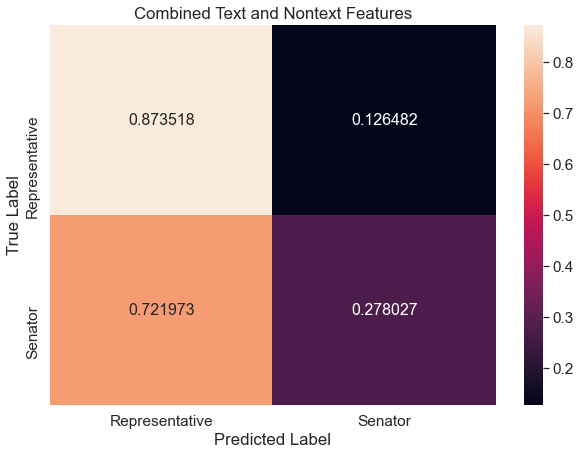

In [64]:
# chamber model
X_train, X_test, y_train, y_test = train_test_split(combined_chamber, chamber, test_size=0.2, random_state=10) 
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)
    
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)
 
# create a model
logit_reg = LogisticRegression(max_iter= 5000)

# fit the model
logit_model = logit_reg.fit(X_train_scaled, y_train.ravel())

y_pred = logit_model.predict(X_val_scaled)
    
cf_matrix = confusion_matrix(y_val, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title("Combined Text and Nontext Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

For both chamber and party, the combined text and non-text features perform better than the text features alone.

### Predict on X_test

Now that we have tuned the logistic regression model, we are ready to predict on our test data and see how well our best model performs on the held-out data.

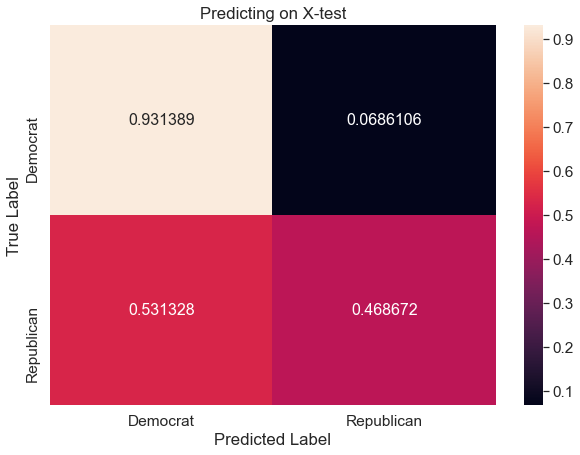

In [65]:
X_train, X_test, y_train, y_test = train_test_split(combined_party, party, test_size=0.2, random_state=10)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# create a model
logit_reg = LogisticRegression(max_iter= 5000) 

# fit the model
logit_model = logit_reg.fit(X_train_scaled, y_train.ravel())

y_pred = logit_model.predict(X_test_scaled)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Predicting on X-test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

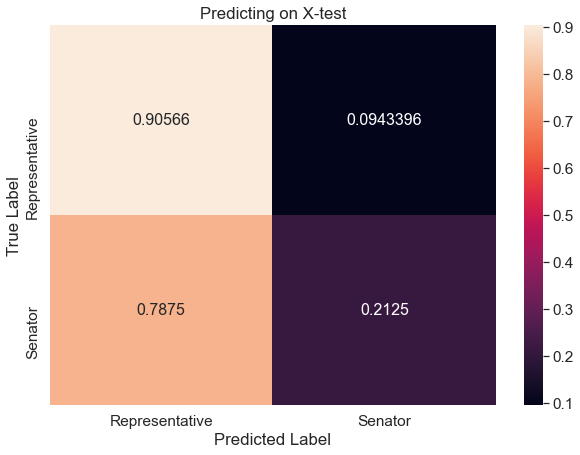

In [66]:
X_train, X_test, y_train, y_test = train_test_split(combined_chamber, chamber, test_size=0.2, random_state=10)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
 
# create a model
logit_reg = LogisticRegression(max_iter= 5000) 

# fit the model
logit_model = logit_reg.fit(X_train_scaled, y_train.ravel())

y_pred = logit_model.predict(X_test_scaled)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Predicting on X-test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**